Obiettivo generale del notebook:
- supportare la strategia dell' e-commerce second hand.
Obiettivo specifico:
- fare analisi del tipo: indentificare taglie e categorie più vendute, esplorare la relazione tra caratteristiche del prodotto e soddisfazione del cliente, ecc.
Stakeholder target:
- team marketing, acquisti, custumer success, ecc.

In [218]:
# BLOCCO 0 - Import e definizioni base (caricamento e pulizia iniziale)
# Qui importo le librerie fondamentali per la data exploration e per test statistici (che userò dopo)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, chi2_contingency

# Caricamento del nuovo file JSON estratto e filtro subito le righe con valori essenziali mancanti
df = pd.read_json("/Users/veramalavolti/Desktop/Master/modcloth_final_data.json", lines=True)

# Elenco colonne disponibili
print("Colonne presenti nel dataset:")
for col in df_prodotti.columns:
    print("-", col)
    
# Nelle colonne chiave metto solo le variabili centrali per l'esplorazione del dataset in funzione del comprendere l'e-commerce di abbigliamento second-hand e anche portare avanti strategie di assortimento, di qualità e di vestibilità.
key_cols = ['size', 'category', 'fit', 'quality', 'bra size', 'cup size']

print("\nValori nulli per colonna chiave prima di dropna:")
print(df[key_cols].isna().sum())
df_clean = df.dropna(subset=key_cols).copy()

print(f"Dataset caricato correttamente: {df.shape[0]} righe × {df.shape[1]} colonne")
display(df.head())

#Esploro le variabili categoriche
print("\nCategorie disponibili in 'category':")
print(df['category'].value_counts())

# Analizzo il tipo di dato per ogni colonna
print("\nTipi di dato per colonna:")
print(df.dtypes)

# Statistiche descrittive (con le colonne numeriche)
print("\nStatistiche descrittive (numeriche):")
display(df.describe())


Colonne presenti nel dataset:
- item_id
- waist
- size
- quality
- cup size
- hips
- bra size
- category
- bust
- height
- user_name
- length
- fit
- user_id
- shoe size
- shoe width
- review_summary
- review_text
- cup size numeric
- standard_size

Valori nulli per colonna chiave prima di dropna:
size           0
category       0
fit            0
quality       68
bra size    6018
cup size    6255
dtype: int64
Dataset caricato correttamente: 82790 righe × 18 colonne


,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN



Categorie disponibili in 'category':
category
new          21488
tops         20364
dresses      18650
bottoms      15266
outerwear     4223
sale          2524
wedding        275
Name: count, dtype: int64

Tipi di dato per colonna:
item_id             int64
waist             float64
size                int64
quality           float64
cup size           object
hips              float64
bra size          float64
category           object
bust               object
height             object
user_name          object
length             object
fit                object
user_id             int64
shoe size         float64
shoe width         object
review_summary     object
review_text        object
dtype: object

Statistiche descrittive (numeriche):


,item_id,waist,size,quality,hips,bra size,user_id,shoe size
count,82790.000000,2882.000000,82790.000000,82722.000000,56064.000000,76772.000000,82790.000000,27915.000000
mean,469325.229170,31.319223,12.661602,3.949058,40.358501,35.972125,498849.564718,8.145818
std,213999.803314,5.302849,8.271952,0.992783,5.827166,3.224907,286356.969459,1.336109
min,123373.000000,20.000000,0.000000,1.000000,30.000000,28.000000,6.000000,5.000000
25%,314980.000000,28.000000,8.000000,3.000000,36.000000,34.000000,252897.750000,7.000000
50%,454030.000000,30.000000,12.000000,4.000000,39.000000,36.000000,497913.500000,8.000000
75%,658440.000000,34.000000,15.000000,5.000000,43.000000,38.000000,744745.250000,9.000000
max,807722.000000,50.000000,38.000000,5.000000,60.000000,48.000000,999972.000000,38.000000


In [202]:
# BLOCCO 1 – Pulizia e mappatura robusta della 'cup size' + standardizzazione taglie
# Definisco un dizionario di mappatura per convertire lettere in numeri ordinali e prepararmi alle prossime analisi
# Stampo un controllo sui valori mappati
# Estendo il lavoro sulle taglie generali per trasformare le taglie numeriche in classi (XXS, XS, ...)

import numpy as np

# Dizionario compatibile direttamente con i dati reali
cup_mapping = {
    'aa': 0,
    'a': 1,
    'b': 2,
    'c': 3,
    'd': 4,
    'dd/e': 5,
    'ddd/f': 6,
    'dddd/g': 7,
    'h': 8,
    'i': 9,
    'j': 10,
    'k': 11
}

# Mappatura diretta: non serve normalizzare se i dati sono già coerenti
df['cup size numeric'] = (
    df['cup size']
    .astype(str)            # se è NaN, diventa 'nan'
    .str.lower()
    .str.strip()
    .replace({
        'dd': 'dd/e', 'e': 'dd/e',
        'ddd': 'ddd/f', 'f': 'ddd/f',
        'dddd': 'dddd/g', 'g': 'dddd/g',
        'none': np.nan, 'nan': np.nan, 'unknown': np.nan
    })
    .map(cup_mapping)
)

# Diagnosi finale dopo la mappatura
mapped = df['cup size numeric'].notna().sum()
total = len(df)
print(f"'cup size' mappate correttamente: {mapped} su {total} righe totali")

# Distribuzione dei valori mappati
print("\nDistribuzione 'cup size numeric':")
print(df['cup size numeric'].value_counts().sort_index())

# Funzione per standardizzare le taglie numeriche
def standardize_size(size):
    try:
        size = int(size)
        if size <= 2: return 'XXS'
        elif size <= 4: return 'XS'
        elif size <= 6: return 'S'
        elif size <= 10: return 'M'
        elif size <= 14: return 'L'
        elif size <= 18: return 'XL'
        else: return 'Plus'
    except:
        return None

# Applico la standardizzazione alla colonna 'size'
df['standard_size'] = df['size'].apply(standardize_size)

# Faccio una diagnostica finale della distribuzione taglie standardizzate
print("\n Distribuzione 'standard_size':")
print(df['standard_size'].value_counts())


'cup size' mappate correttamente: 76535 su 82790 righe totali

Distribuzione 'cup size numeric':
cup size numeric
0.0       296
1.0      4791
2.0     14628
3.0     18370
4.0     16149
5.0     12557
6.0      6117
7.0      2008
8.0      1042
9.0       189
10.0      200
11.0      188
Name: count, dtype: int64

 Distribuzione 'standard_size':
standard_size
M       20571
L       18735
Plus    18555
XS      14025
XL       7369
XXS      1909
S        1626
Name: count, dtype: int64


In [204]:
# BLOCCO 1B – Pulizia e filtro delle categorie
# Elimina la categorie che non sono parte integrante delle tipologie di abbigliamento (es. "nuovo", o "sale")
categorie_escluse = ['new', 'sale']
df_prodotti = df[~df['category'].isin(categorie_escluse)].copy()

print("🔍 Categorie escluse:", categorie_escluse)
print("\n✅ Prime 5 categorie valide dopo il filtro:")
print(df_prodotti['category'].value_counts().head())

🔍 Categorie escluse: ['new', 'sale']

✅ Prime 5 categorie valide dopo il filtro:
category
tops         20364
dresses      18650
bottoms      15266
outerwear     4223
wedding        275
Name: count, dtype: int64


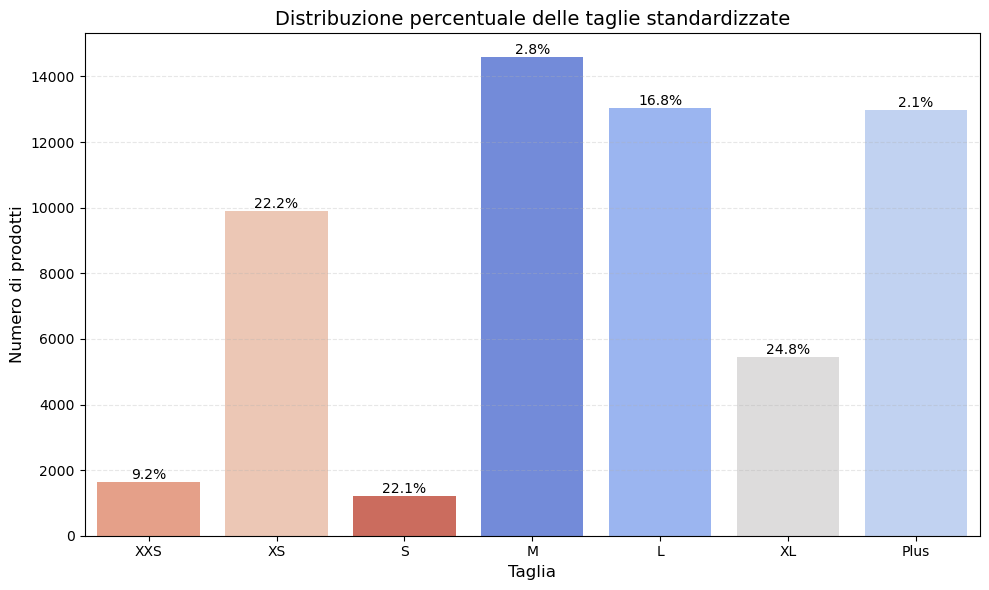

In [264]:
# BLOCCO 2A - Distribuzione delle taglie standardizzate
# Analizziamo la distribuzione generale delle taglie standardizzate create a partire dal campo 'size'
# Visualizzazione della distribuzione delle taglie standardizzate (con un countplot)

taglia_counts = df_prodotti['standard_size'].value_counts(normalize=True).reindex(order) * 100

# Visualizzazione con annotazioni
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df_prodotti,
    x='standard_size',
    order=order,
    hue='standard_size',  # serve per usare palette
    palette='coolwarm',
    legend=False  # disattiva legenda ripetitiva
)
for p, perc in zip(ax.patches, taglia_counts):
    height = p.get_height()
    ax.annotate(f'{perc:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.title("Distribuzione percentuale delle taglie standardizzate", fontsize=14)
plt.xlabel("Taglia", fontsize=12)
plt.ylabel("Numero di prodotti", fontsize=12)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.show()

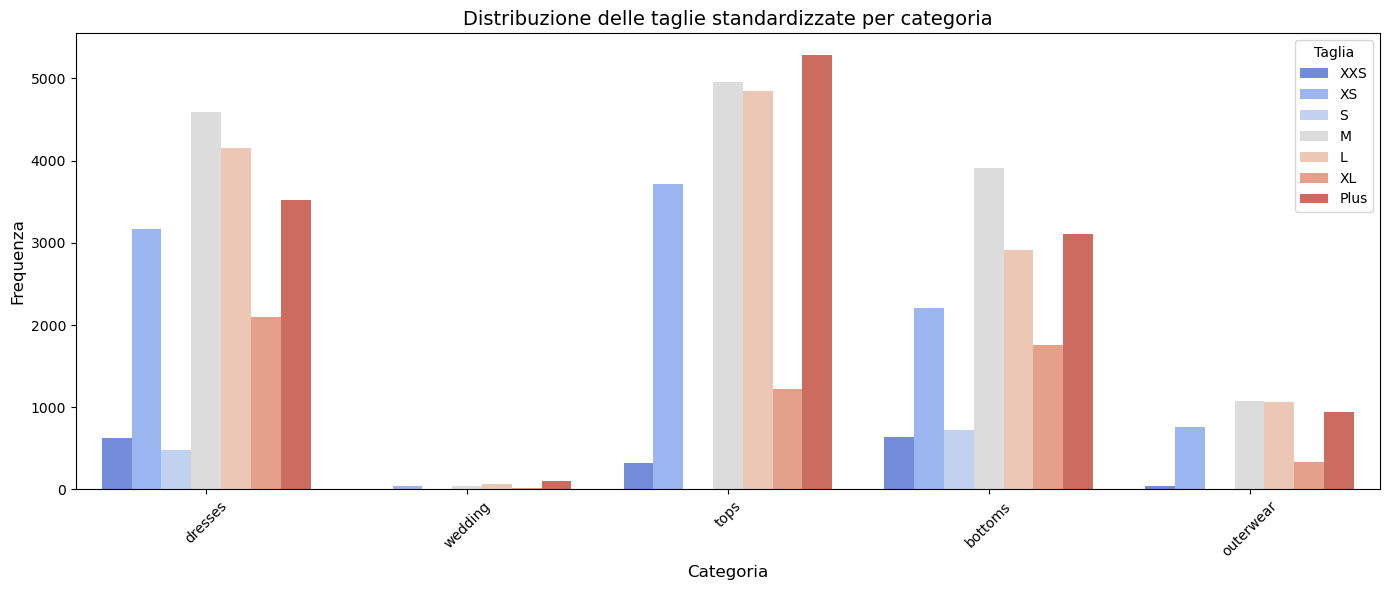

In [216]:
#BLOCCO 2B (Distribuzione delle taglie standardizzate per categoria)
# Visualizzazione: quali taglie standardizzate sono presenti per ciascuna categoria
# Grafico a barre della distribuzione delle taglie per categoria
# BLOCCO 2B – Distribuzione taglie per categoria
plt.figure(figsize=(14, 6))
order_cat = df_prodotti['category'].value_counts().index[:10]  # prime 10 categorie
sns.countplot(
    data=df_prodotti[df_prodotti['category'].isin(order_cat)],
    x='category',
    hue='standard_size',
    hue_order=['XXS', 'XS', 'S', 'M', 'L', 'XL', 'Plus'],
    palette='coolwarm'
)

plt.title("Distribuzione delle taglie standardizzate per categoria", fontsize=14)
plt.xlabel("Categoria", fontsize=12)
plt.ylabel("Frequenza", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Taglia")
plt.tight_layout()
plt.show()


Frequenza delle taglie per categoria (prime righe):


standard_size,L,M,Plus,S,XL,XS,XXS
category,,,,,,,
tops,4848,4959,5284,9,1224,3717,323
dresses,4154,4595,3523,484,2096,3169,629
bottoms,2917,3910,3109,724,1762,2210,634
outerwear,1064,1074,944,0,333,764,44
wedding,61,47,104,2,20,40,1


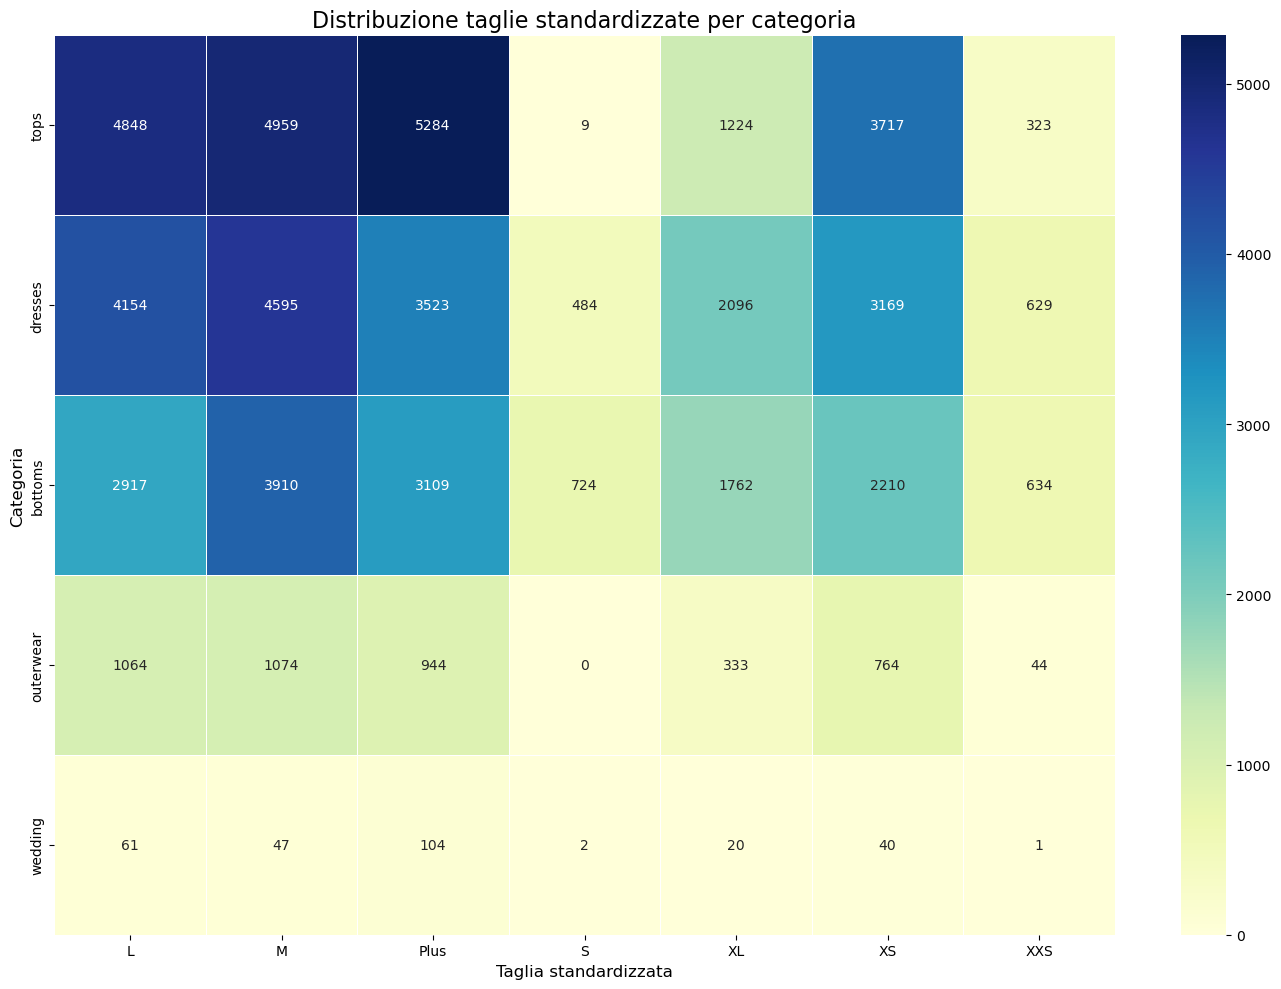

In [212]:
# BLOCCO 2C – Tabella incrociata cross-tab tra categoria di abbigliamento e la sua taglia standardizzata
# Mi fa anche vedere il numero delle osservazioni per ogni coppia categoria x taglia

# Qui: ordina le categorie in base alla frequenza totale
categorie_ordinate = df_prodotti['category'].value_counts().index

# Poi costruisce la tabella incrociata ordinata
tabella_taglie = pd.crosstab(
    df_prodotti['category'],
    df_prodotti['standard_size']
).loc[categorie_ordinate]

# Mi mostra la tabella con le frequenze assolute
print("Frequenza delle taglie per categoria (prime righe):")
display(tabella_taglie.head(10))  # eventualmente limitare output se tabella grande

# Fa la heatmap per stakeholder: rende visivo l'assortimento
plt.figure(figsize=(14, 10))
sns.heatmap(tabella_taglie, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)

plt.title("Distribuzione taglie standardizzate per categoria", fontsize=16)
plt.xlabel("Taglia standardizzata", fontsize=12)
plt.ylabel("Categoria", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Boxplot per confrontare la qualità per categoria --> sulla 3
**

In [222]:
# BLOCCO 3A – Pulizia misure corporee e conversioni numeriche
# Dopo una breve esplorazione visiva e aggregata delle taglie e categorie (Blocco 2A - 2C) approfondisco le caratteristiche fisiche associate alle recensioni
# Introducendo le misure corporee spiego il "perché" dei fit. 

import re

# Conversione colonne numeriche
for col in ['bra size', 'waist', 'hips']:
    df_prodotti[col] = pd.to_numeric(df_prodotti[col], errors='coerce')

# Conversione altezza da '5ft 2in' a centimetri
def height_to_cm(h):
    if isinstance(h, str):
        match = re.match(r"(\d+)[\s']*ft[\s']*(\d+)[\s\"]*in", h.lower()) or re.match(r"(\d+)'(\d+)", h)
        if match:
            feet, inches = int(match.group(1)), int(match.group(2))
            return round(feet * 30.48 + inches * 2.54, 1)
    return None

df_prodotti['height_cm'] = df_prodotti['height'].apply(height_to_cm)

# Diagnostica dei dati validi
print("📌 Numero di valori non nulli disponibili per le analisi corporee:")
print(df_prodotti[['cup size numeric', 'bra size', 'waist', 'hips', 'height_cm']].notna().sum())


📌 Numero di valori non nulli disponibili per le analisi corporee:
cup size numeric    54253
bra size            54391
waist                2103
hips                39942
height_cm           55949
dtype: int64


In [228]:
# BLOCCO 3B – Calcola le misure corporee medie per categoria e le ordina in base alla statura media
# Permette di personalizzare vestibilità, consigli e taglie attese.
# Es. può essere utile per segmentare i dati e poi clusterizzare in futuro.

# Colonne numeriche da analizzare
variabili_misura = ['bra size', 'cup size numeric', 'waist', 'hips', 'height_cm']

# Calcolo medie per categoria, ordinate per altezza media decrescente
stat_misure = (
    df_prodotti
    .groupby('category')[variabili_misura]
    .mean()
    .round(1)
    .sort_values(by='height_cm', ascending=False)
)

print("Medie misure corporee per categoria (prime 10):")
display(stat_misure.head(10))


Medie misure corporee per categoria (prime 10):


,bra size,cup size numeric,waist,hips,height_cm
category,,,,,
bottoms,35.7,3.7,31.2,40.2,166.1
tops,36.2,3.7,31.5,40.7,166.0
outerwear,35.8,3.6,31.1,40.1,165.9
wedding,37.2,3.8,33.5,42.5,165.6
dresses,35.8,3.6,31.0,40.0,165.1


Numero di valori non nulli per ciascuna variabile:
bra size            54391
cup size numeric    54253
quality             58731
size                58778
dtype: int64


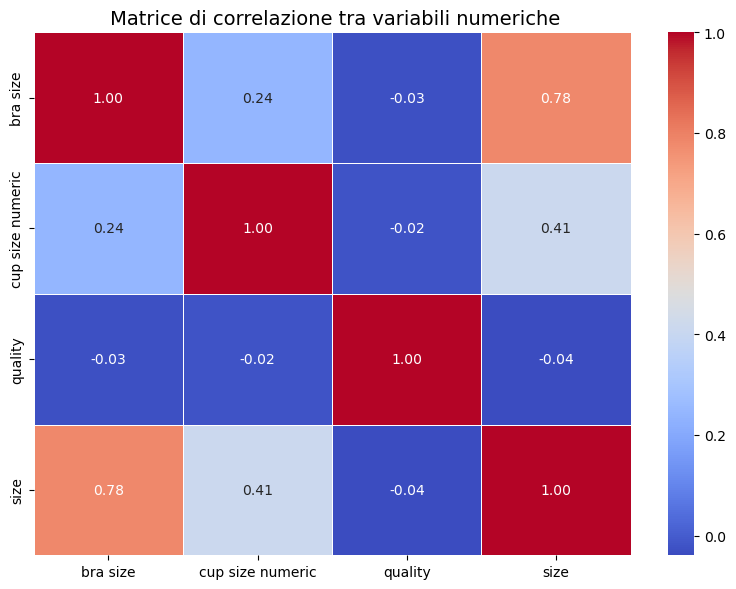


 Nota per stakeholder:
- Correlazioni alte suggeriscono relazioni strutturali (es. size ~ bra size)
- Utile per ottimizzare il fitting automatico o suggerimenti taglia.


In [236]:
# BLOCCO 4 – Matrice di correlazione tra variabili numeriche
# Aiuta molto a capire se ci sono delle misure corporee che possono predirne altre (per es. una bra_size e una size generica)
# Nell'ottica di uno stakeholder serve per validare la coerenza interna ai dati e può servire per modelli predittivi oppure un'automazione delle raccomandazioni

# Selezione delle variabili numeriche da analizzare
corr_cols = ['bra size', 'cup size numeric', 'quality', 'size']

# Diagnostica sui dati disponibili
print("Numero di valori non nulli per ciascuna variabile:")
print(df_prodotti[corr_cols].notna().sum())

# Costruzione del dataset valido per la correlazione
corr_data = df_prodotti[corr_cols].dropna()

if corr_data.empty:
    print(" Nessun dato valido per calcolare la matrice di correlazione.")
else:
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

    plt.title(" Matrice di correlazione tra variabili numeriche", fontsize=14)
    plt.tight_layout()
    plt.show()

    print("\n Nota per stakeholder:")
    print("- Correlazioni alte suggeriscono relazioni strutturali (es. size ~ bra size)")
    print("- Utile per ottimizzare il fitting automatico o suggerimenti taglia.")


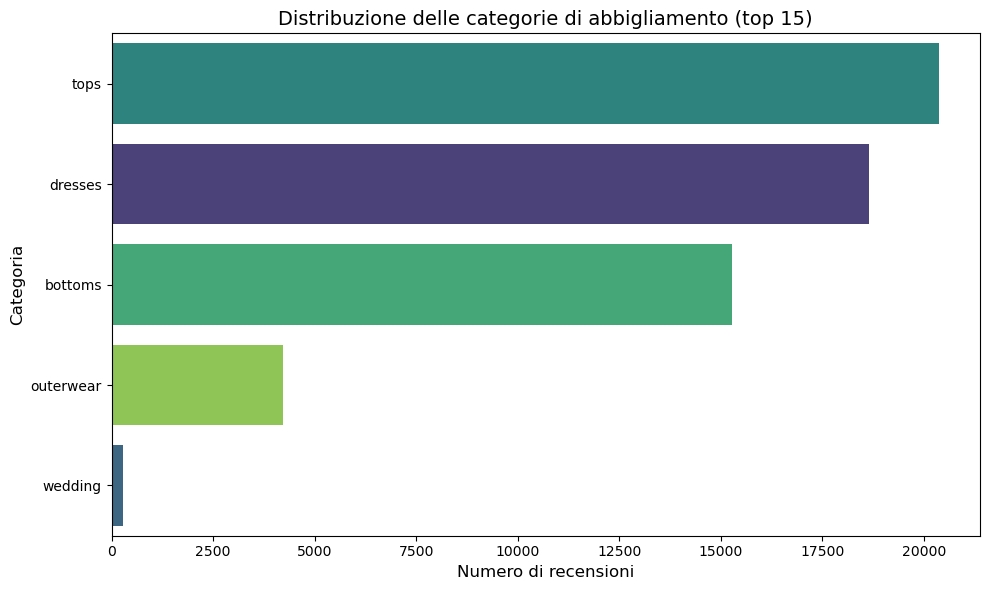

In [242]:
# BLOCCO 5
# Utile nella comprensione della struttura del dataset: distribuzione delle categorie di abbigliamento

plt.figure(figsize=(10, 6))

# Visualizza solo le top 15 categorie (questione di chiarezza)
top_categories = df_prodotti['category'].value_counts().nlargest(15).index

sns.countplot(
    data=df_prodotti[df_prodotti['category'].isin(top_categories)],
    y='category',
    hue='category',
    order=top_categories,
    palette='viridis',
    legend=False
)

plt.title("Distribuzione delle categorie di abbigliamento (top 15)", fontsize=14)
plt.xlabel("Numero di recensioni", fontsize=12)
plt.ylabel("Categoria", fontsize=12)
plt.tight_layout()
plt.show()

/var/folders/vs/ldt4d40j433byhv7lp64n06m0000gn/T/ipykernel_98585/2732914647.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


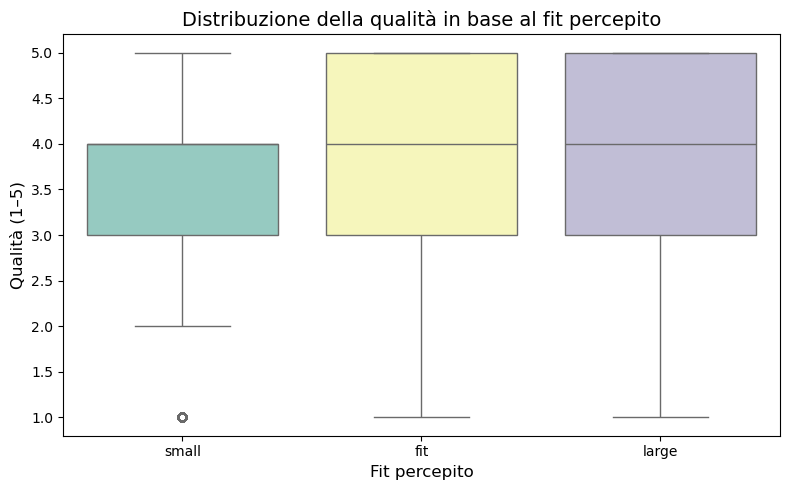

Kruskal-Wallis H-test: H = 2445.51, p = 0.0000
Differenze statisticamente significative tra i gruppi di fit.


In [244]:
# BLOCCO 6 - Ipotesi 1: quality più alta quando il fit è "fit"
# Uso il boxplot per mostrare la distrubuzione del punteggio di qualità in funzione della percezione del fit

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_prodotti,
    x='fit',
    y='quality',
    order=['small', 'fit', 'large'],
    palette='Set3'
)
plt.title("Distribuzione della qualità in base al fit percepito", fontsize=14)
plt.xlabel("Fit percepito", fontsize=12)
plt.ylabel("Qualità (1–5)", fontsize=12)
plt.tight_layout()
plt.show()

# Test di Kruskal-Wallis per verificare se i gruppi di fit hanno qualità diverse
fit_groups = [
    group['quality'].dropna().values
    for name, group in df_prodotti.groupby('fit')
    if name in ['small', 'fit', 'large']
]

stat, p = kruskal(*fit_groups)
print(f"Kruskal-Wallis H-test: H = {stat:.2f}, p = {p:.4f}")
if p < 0.05:
    print("Differenze statisticamente significative tra i gruppi di fit.")
else:
    print("Nessuna differenza significativa nella qualità media tra i gruppi.")


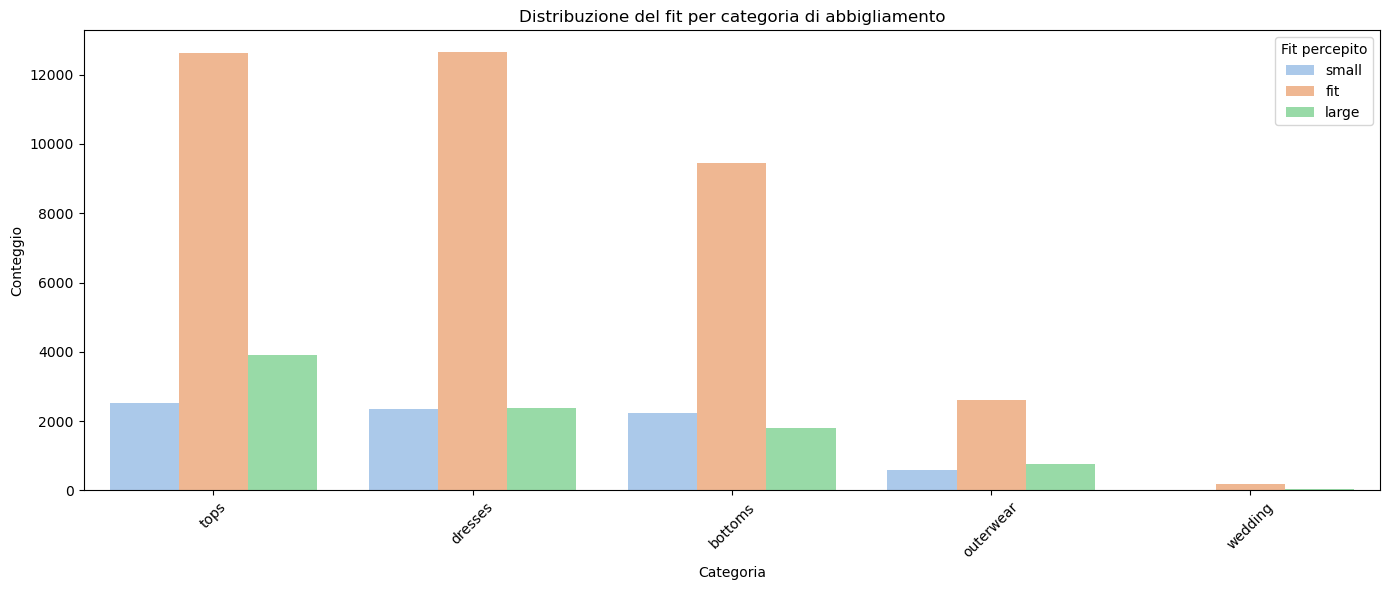

Chi-quadro test interazione size/category/fit: chi2 = 18847.50, p = 0.0000


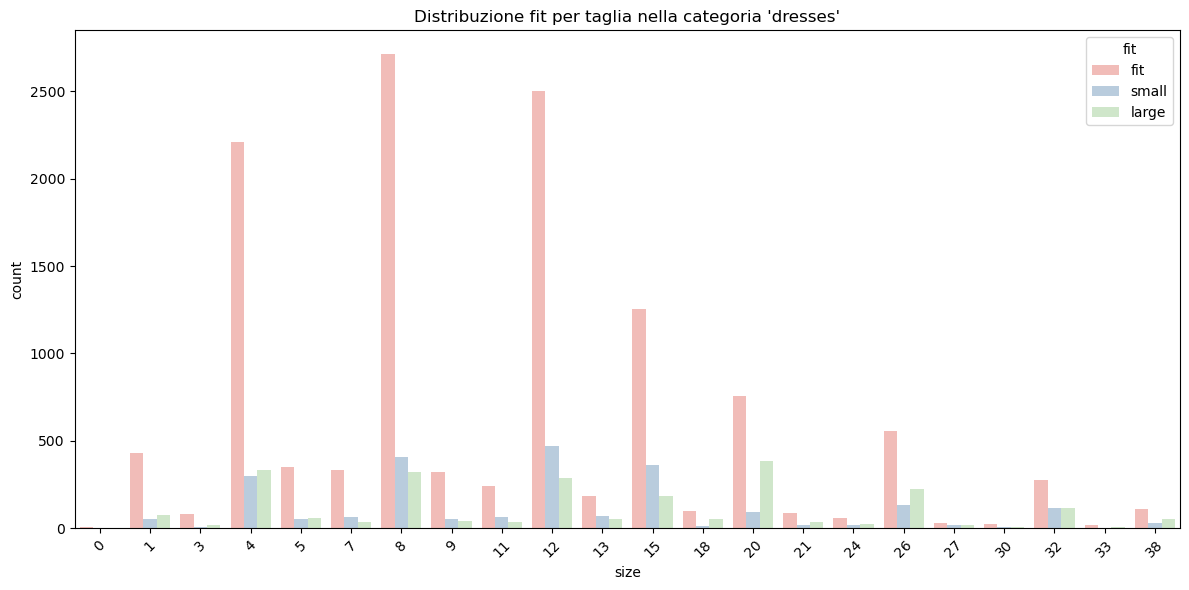

In [28]:

# BLOCCO 7 - Ipotesi 2: il legame taglia-fit cambia a seconda della categoria
# Aggiunta visualizzazione globale del fit per categoria
# Escludiamo le categorie che non rappresentano veri capi
fit_order = ['small', 'fit', 'large']
df_fit_filtered = df_clean[~df_clean['category'].isin(['new', 'sale'])]
order = df_fit_filtered['category'].value_counts().index

plt.figure(figsize=(14, 6))
sns.countplot(data=df_fit_filtered, x='category', hue='fit', order=order, hue_order=fit_order, palette='pastel')
plt.xticks(rotation=45)
plt.title("Distribuzione del fit per categoria di abbigliamento")
plt.xlabel("Categoria")
plt.ylabel("Conteggio")
plt.legend(title="Fit percepito")
plt.tight_layout()
plt.show()
pivot = pd.crosstab(index=df_clean['size'], columns=[df_clean['category'], df_clean['fit']])
if pivot.shape[0] > 0 and pivot.shape[1] > 0:
    chi2, p, dof, expected = chi2_contingency(pivot.fillna(0))
    print(f"Chi-quadro test interazione size/category/fit: chi2 = {chi2:.2f}, p = {p:.4f}")

    # Visualizzazione: fit per taglia per una categoria esemplificativa
    category_example = 'dresses'
    subset = df_clean[df_clean['category'] == category_example]
    plt.figure(figsize=(12, 6))
    sns.countplot(data=subset, x='size', hue='fit', palette='Pastel1')
    plt.title(f"Distribuzione fit per taglia nella categoria '{category_example}'")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Dati insufficienti per il test di chi-quadro.")

In [246]:
# BLOCCO 7 – Test inferenziali
from scipy.stats import kruskal, chi2_contingency

# Test Kruskal: calcola la qualità in base alla taglia (quindi se le medie di 'quality' cambiano tra gruppi di taglia)
gruppi_qualità = [group['quality'].values for _, group in df_prodotti.groupby('standard_size')]
stat, p = kruskal(*gruppi_qualità)

print(f"Test di Kruskal-Wallis (qualità vs taglia):")
print(f"Statistic: {stat:.2f}, p-value: {p:.4f}")
if p < 0.05:
    print("Differenza significativa tra le taglie.")
else:
    print("Nessuna differenza significativa tra le taglie.")

# Test Chi²: verifica se c'è una dipendenza tra taglia e fit percepito
contingenza = pd.crosstab(df_prodotti['standard_size'], df_prodotti['fit'])
chi2, p_chi2, dof, expected = chi2_contingency(contingenza)

print(f"Test Chi² (fit vs taglia):")
print(f"Chi²: {chi2:.2f}, p-value: {p_chi2:.4f}")
if p_chi2 < 0.05:
    print("Esiste un'associazione significativa tra taglia e fit percepito.")
else:
    print("Nessuna associazione significativa.")


Test di Kruskal-Wallis (qualità vs taglia):
Statistic: nan, p-value: nan
Nessuna differenza significativa tra le taglie.
Test Chi² (fit vs taglia):
Chi²: 1370.49, p-value: 0.0000
Esiste un'associazione significativa tra taglia e fit percepito.


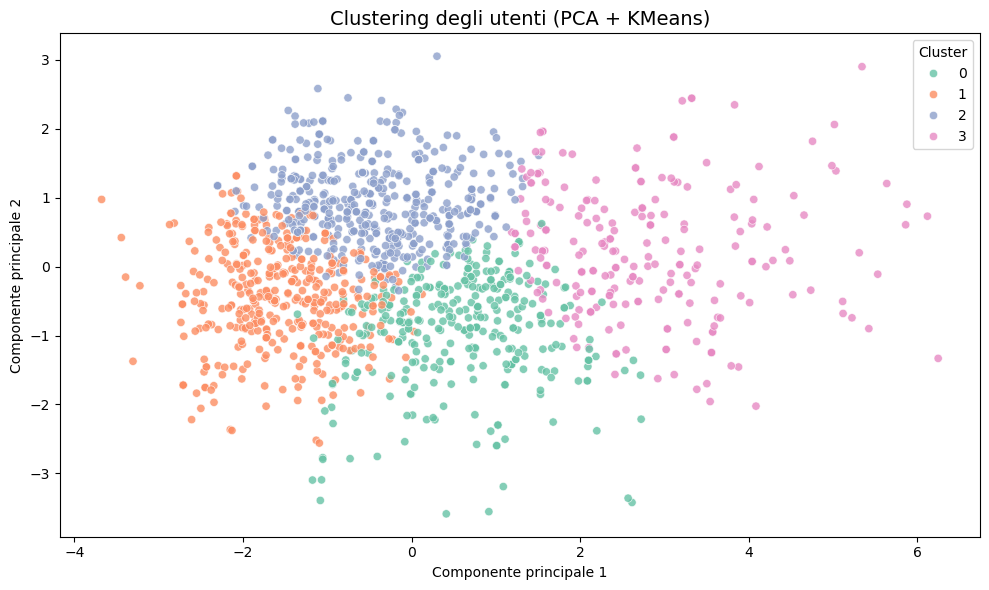

Numero di utenti per cluster:
cluster
0    339
1    407
2    490
3    227
Name: count, dtype: int64

Medie per cluster:


,bra size,cup size numeric,waist,hips,height_cm,quality
cluster,,,,,,
0,35.55,5.24,33.05,41.73,162.91,4.08
1,33.20,2.70,27.20,35.82,160.22,3.95
2,35.04,2.73,29.44,38.90,170.81,4.36
3,40.04,4.12,40.33,48.55,167.58,4.25


In [250]:
# BLOCCO 8 – Clustering avanzato degli utenti: per segmentare gli utenti in gruppi simili tra di loro in base al comportamento e alle caratteristiche corporee
# Per esempio, utile per marketing personalizzato oppure anche suggerire prodotti corerenti con il profilo tipo.

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Selezione delle variabili per il clustering
clustering_vars = ['bra size', 'cup size numeric', 'waist', 'hips', 'height_cm', 'quality']

# Filtra solo righe complete
df_cluster = df_prodotti.dropna(subset=clustering_vars).copy()

# Standardizzazione dei dati
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[clustering_vars])

# Riduzione dimensionale per visualizzazione (PCA 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Clustering KMeans
n_clusters = 4  # si può modificare dopo analisi silhouette
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# Aggiunge le componenti principali per visualizzazione
df_cluster['PCA1'] = X_pca[:, 0]
df_cluster['PCA2'] = X_pca[:, 1]

# Visualizzazione dei cluster su PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='cluster', palette='Set2', alpha=0.8)
plt.title("Clustering degli utenti (PCA + KMeans)", fontsize=14)
plt.xlabel("Componente principale 1")
plt.ylabel("Componente principale 2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Analisi descrittiva dei cluster
print("Numero di utenti per cluster:")
print(df_cluster['cluster'].value_counts().sort_index())

print("\nMedie per cluster:")
display(df_cluster.groupby('cluster')[clustering_vars].mean().round(2))


In [254]:
#A partire dai risultati esplorativi e inferenziali che ho raccolto nei BLOCCHI da 0 a 8 ora posso avanziare strategie di assortimento basate su evidenze analitiche.
# BLOCCO 9 – Proposta strategica per l’assortimento iniziale del catalogo
# Qui ottengo un quadro oggettivo delle priorità da cui partire per selezionare i capi + una rpoposta giustificata dai dati + una base per la strategia data-driven

# 1. Categorie più rappresentate
print("Le categorie con più recensioni (priorità per l’assortimento):")
display(df_prodotti['category'].value_counts().head())

# 2. Taglie più diffuse in generale
print("\nLe taglie più frequenti tra gli utenti:")
display(df_prodotti['standard_size'].value_counts(normalize=True).mul(100).round(1))

# 3. Fit percepito per le taglie più vendute
print("\nFit percepito per le taglie principali (XXS–Plus):")
fit_by_size = pd.crosstab(df_prodotti['standard_size'], df_prodotti['fit'], normalize='index').round(2)
display(fit_by_size)

# 4. Cluster di utenti (da KMeans)
print("\nSegmentazione utenti (profili corporei medi):")
cluster_profiles = df_cluster.groupby('cluster')[['bra size', 'cup size numeric', 'waist', 'hips', 'height_cm']].mean().round(1)
display(cluster_profiles)


Le categorie con più recensioni (priorità per l’assortimento):


category
tops         20364
dresses      18650
bottoms      15266
outerwear     4223
wedding        275
Name: count, dtype: int64


Le taglie più frequenti tra gli utenti:


standard_size
M       24.8
L       22.2
Plus    22.1
XS      16.8
XL       9.2
XXS      2.8
S        2.1
Name: proportion, dtype: float64


Fit percepito per le taglie principali (XXS–Plus):


fit,fit,large,small
standard_size,,,
L,0.70,0.13,0.17
M,0.74,0.14,0.12
Plus,0.60,0.24,0.16
S,0.78,0.11,0.11
XL,0.67,0.13,0.19
XS,0.73,0.17,0.09
XXS,0.72,0.17,0.11



Segmentazione utenti (profili corporei medi):


,bra size,cup size numeric,waist,hips,height_cm
cluster,,,,,
0,35.5,5.2,33.1,41.7,162.9
1,33.2,2.7,27.2,35.8,160.2
2,35.0,2.7,29.4,38.9,170.8
3,40.0,4.1,40.3,48.5,167.6


In [256]:
df_nlp = df[['review_text']].dropna().copy()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/veramalavolti/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/var/folders/vs/ldt4d40j433byhv7lp64n06m0000gn/T/ipykernel_98585/25750744.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keywords_freq.values[:20], y=keywords_freq.index[:20], palette='magma')


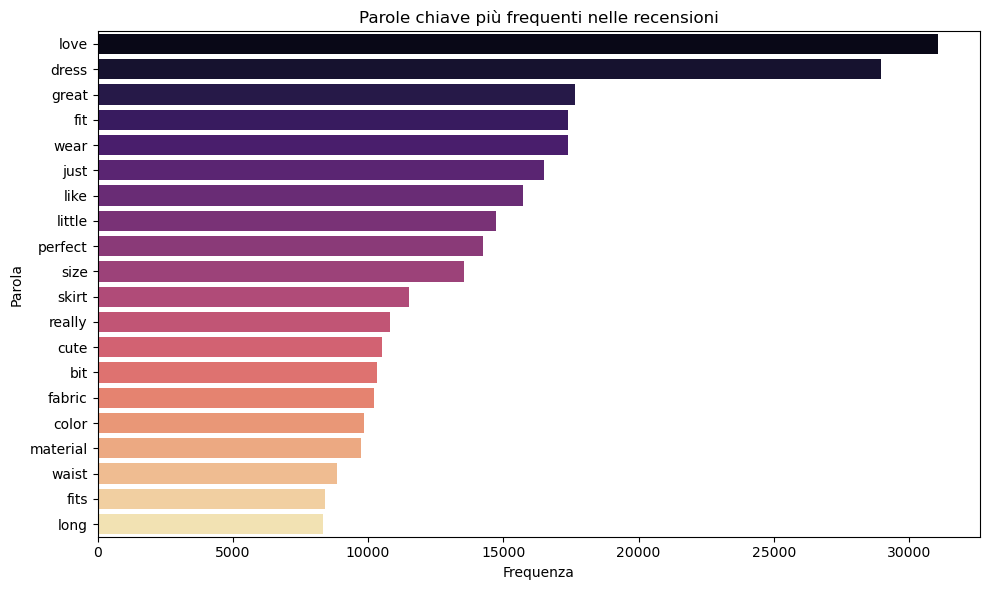

Distribuzione del sentiment:
sentiment
positivo    67980
negativo     4801
neutro       3284
Name: count, dtype: int64


In [262]:
# Qui avrei voluto aprire una parentesi di integrazione con altri dataset, ma le categorie del json non sono particolarmente stimolanti in questo senso.
# Per cui: BLOCCO 10 – Analisi NLP: Sentiment + Parole chiave
# Può essere utile per capire come parlano i clienti (utile per il marketing copy o tagging automatico)

import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Scarica risorsa VADER solo la prima volta
nltk.download('vader_lexicon')

# Caricamento dataset (modifica il path se necessario)
df = pd.read_json("modcloth_final_data.json", lines=True)

# Pulisci dati
df_nlp = df[['review_text']].dropna().copy()

# Analisi del sentiment
sia = SentimentIntensityAnalyzer()

def classify_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positivo'
    elif score <= -0.05:
        return 'negativo'
    else:
        return 'neutro'

df_nlp['sentiment'] = df_nlp['review_text'].apply(classify_sentiment)

# Estrazione parole chiave
vectorizer = CountVectorizer(stop_words='english', max_features=50)
X_keywords = vectorizer.fit_transform(df_nlp['review_text'])

# Frequenze
keywords_freq = pd.Series(X_keywords.toarray().sum(axis=0), index=vectorizer.get_feature_names_out()).sort_values(ascending=False)

# Visualizza parole chiave
plt.figure(figsize=(10, 6))
sns.barplot(x=keywords_freq.values[:20], y=keywords_freq.index[:20], palette='magma')
plt.title("Parole chiave più frequenti nelle recensioni")
plt.xlabel("Frequenza")
plt.ylabel("Parola")
plt.tight_layout()
plt.show()

# Output finale
print("Distribuzione del sentiment:")
print(df_nlp['sentiment'].value_counts())
